In [6]:
#import libraries
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,make_scorer
from sklearn.model_selection import KFold,GridSearchCV
from scipy.stats import skew, kurtosis
from lightgbm import LGBMRegressor


In [2]:
#Constants

PRIMARY_KEY = ['warehouse','date']

CUT_DATE = '2023-12-15'

PRIMARY_KEY = ['warehouse','date']
DROP_COLS = ['id', 'warehouse_limited']
LINEAR_COLS = ['year', 'day_num', 'continuous_holiday', 'continuous_shut_down_before', 'delta_days']
CATE_COLS = ['warehouse']
DATE_COLS = ['month', 'week_of_year', 'quarter']
WEEKDAY_COLS = ['weekday']
BOOL_COLS = ['holiday', 'shops_closed', 'school_holidays', 'winter_school_holidays', 
             'is_quarter_start', 'is_quarter_end', 'is_month_start', 'is_month_end',
             'is_weekend']
HOLIDAY_NAME_COLS = []
target_cols = ['orders', 'user_activity_1', 'user_activity_2']
FEATURES_COLS = [DROP_COLS, LINEAR_COLS, CATE_COLS, DATE_COLS, WEEKDAY_COLS, BOOL_COLS, HOLIDAY_NAME_COLS]

LABEL1 = ['shutdown', 'snow', 'precipitation', 'mov_change', 'frankfurt_shutdown', 'blackout', 'mini_shutdown', 'user_activity_1', 'user_activity_2']
LABEL2 = ['orders']



In [3]:
#Drop Columns
def drop_columns(df, cols):
    cols_need_drop = list(set(cols) & set(df.columns))
    if len(cols_need_drop) > 0:
        return df.drop(cols_need_drop, axis=1)
    return df

#Sort data by warehouse-date
def sort_by_warehouse_and_date(df):
    return df.sort_values(['warehouse', 'date']).reset_index(drop=True)


# Identify Warehouse working & non-working days
def fill_warehouse_closed_days(calendar, data):
    if 'warehouse_work_day' in calendar.columns:
        calendar.drop('warehouse_work_day', axis=1, inplace=True)
    df1 = calendar.copy()
    df2 = data[['warehouse', 'date']].copy()
    
    df1 = sort_by_warehouse_and_date(df1)
    df2 = sort_by_warehouse_and_date(df2)
    
    df2['warehouse_work_day'] = True
    df1 = pd.merge(df1, df2, how='left', on=['warehouse', 'date'])
    df1['warehouse_work_day'] = df1['warehouse_work_day'].fillna(False).astype(bool)
    return df1


def merge_information_and_train_test_set(calendar_train, df_train, calendar_test, df_test):
    extra_info = list(set(LABEL1+LABEL2) - set(calendar_train))
    df = pd.merge(calendar_train, df_train[PRIMARY_KEY + extra_info], how='left', on=['warehouse','date'])
    features = df.drop(LABEL1+LABEL2, axis=1)
    labels = df[PRIMARY_KEY+LABEL1+LABEL2]
    features['train'] = True
    calendar_test['train'] = False
    features = pd.concat([features, calendar_test])
    features = sort_by_warehouse_and_date(features)
    labels = sort_by_warehouse_and_date(labels)
    return features, labels


def calculate_continuous_closed_days(df):
    # Create a new column 'warehouse_non_work_day' where 'normal_work' is False (0) or True (1)
    df['warehouse_non_work_day'] = (~df['warehouse_work_day']).astype('int32')
    
    df = df.sort_values(by=['warehouse', 'date']).reset_index(drop=True)
    
    # Calculate continuous holidays (consecutive days ahead) for each warehouse. 
    # Helps Companies know non-working days in advance.
    df['continuous_holiday'] = df.groupby('warehouse')['warehouse_non_work_day'].apply(
        lambda x: x[::-1].groupby((x != x.shift()).cumsum()).cumsum()[::-1] * x
    )
    
    df = df.drop('warehouse_non_work_day', axis=1)
    
    return df

def calculate_continuous_shut_down_before(df):
    df['warehouse_non_work_day'] = (~df['warehouse_work_day']).astype('int32')
    df = df.sort_values(by=['warehouse', 'date']).reset_index(drop=True)
    
    
    # Calculate continuous holidays shutdown before today --- for each warehouse. 
    # Helps Companies in staffing appropriately, Inventory mgmt etc
    
    df['continuous_shut_down_before'] = df.groupby('warehouse')['warehouse_non_work_day'].apply(
        lambda x: x[::-1].cumsum()[::-1].shift(-1, fill_value=0)
    )
    
    df = df.drop('warehouse_non_work_day', axis=1)
    LINEAR_COLS.append('continuous_shut_down_before')
    return df


def away_from_holiday(df, window=5, sort=True):
    df['holiday_(0)'] = False
    df.loc[~df['holiday_name'].isna(), 'holiday_(0)'] = True
    df['holiday_name'] = df['holiday_name'].fillna('not_holiday')
    BOOL_COLS.append('holiday_(0)')
    HOLIDAY_NAME_COLS.append('holiday_name')
    for i in range(1, window):
        df[[f'holiday_name_{i}', f'holiday_(-{i})']] = df.groupby('warehouse')[['holiday_name','holiday_(0)']].shift(-i)

        df[f'holiday_name_{i}'] = df[f'holiday_name_{i}'].fillna('not_holiday')
        df[f'holiday_(-{i})'] = df[f'holiday_(-{i})'].fillna(False)
        BOOL_COLS.append(f'holiday_(-{i})')
        HOLIDAY_NAME_COLS.append(f'holiday_name_{i}')
    return df
        
def after_holiday(df, window=1):
    for i in range(1, window + 1):
        shifted = df.groupby('warehouse')[['holiday_name', 'holiday_(0)']].shift(i)
        df[f'holiday_name_{-i}'] = shifted['holiday_name'].fillna('not_holiday')
        df[f'holiday_({i})'] = shifted['holiday_(0)'].fillna(False)
        
        BOOL_COLS.append(f'holiday_({i})')
        HOLIDAY_NAME_COLS.append(f'holiday_name_{-i}')
    
    return df

def add_season(num):
    if num in [3 ,4, 5]:
        return 1
    elif num in [6, 7, 8]:
        return 2
    elif num in [9, 10, 11]:
        return 3
    else:
        return 4

def split_date(df, date_column):
    date_type = 'datetime64[ns]'
    if df[date_column].dtype != date_type:
        df[date_column] = df[date_column].astype(date_type)
    
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['weekday'] = df[date_column].dt.weekday + 1
    df['season'] = df['month'].apply(add_season)
    
    LINEAR_COLS.append('season')
    
    return df

def get_advanced_date_information(df, date_column):
    df['week_of_year'] = df[date_column].dt.isocalendar().week.fillna(-1)
    df['quarter'] = df[date_column].dt.quarter.fillna(-1)
    df['is_month_start'] = df[date_column].dt.is_month_start.astype(int).fillna(-1)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int).fillna(-1)
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int).fillna(-1)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int).fillna(-1)
    df['is_weekend'] = df[date_column].dt.weekday.isin([5, 6]).astype(int)
    
    df['day_num'] = df[date_column].dt.dayofyear.fillna(-1)
    df['delta_days'] = (df[date_column] - df[date_column].min()).dt.days
    df['week_of_year_for_lag_order'] = df['day_num'] // 7 + 1
    
    return df

# test
def get_full_train_set(features, labels):
    return pd.merge(labels, features, how='left', on=PRIMARY_KEY)

def make_orders_ratio(features, labels):
    df = get_full_train_set(features, labels)
    
    orders_sum_of_week = df.groupby(['warehouse', 'week_of_year', 'year'])['orders'].sum().reset_index()
    df = pd.merge(df, orders_sum_of_week, how='left', on=['warehouse', 'week_of_year', 'year'], suffixes=('', '_sum_of_week'))
    df['orders_ratio_of_week'] = df['orders'] / df['orders_sum_of_week']
    df = df.drop('orders_sum_of_week', axis=1)
    
    orders_sum_of_month = df.groupby(['warehouse', 'month', 'year'])['orders'].sum().reset_index()
    df = pd.merge(df, orders_sum_of_month, how='left', on=['warehouse', 'month', 'year'], suffixes=('', '_sum_of_month'))
    df['orders_ratio_of_month'] = df['orders'] / df['orders_sum_of_month']
    df = df.drop('orders_sum_of_month', axis=1)
    
    labels = pd.merge(labels, df[['warehouse', 'date', 'orders_ratio_of_week', 'orders_ratio_of_month']], how='left', on=PRIMARY_KEY)
    return labels

def target_encoding(features, labels, cols, n_splits=5):
    train = features.loc[features['train'] == True]
    train = pd.merge(train, labels[target_cols+['date', 'warehouse']], how='left', on=['date', 'warehouse'])
    mean_target = train[target_cols].mean()
    for col in cols:
        for target in target_cols:
            features[f"{col}_{target}_target_encoded_mean"] = features[col].map(train.groupby(col)[target].mean()).fillna(0)

            features[f"{col}_{target}_target_encoded_std"] = features[col].map(train.groupby(col)[target].std()).fillna(0)
            na_count = features[f"{col}_{target}_target_encoded_mean"].isna().sum()
            if na_count > 0:
                print(f"{col} has nan count {na_count} before fillna, will fill {mean_target[target].mean()}")
            features[f"{col}_{target}_target_encoded_mean"] = features[f"{col}_{target}_target_encoded_mean"].fillna(mean_target[target].mean())
            na_count = features[f"{col}_{target}_target_encoded_mean"].isna().sum()
            if na_count > 0:
                print(f"{col} has nan count {na_count} after fillna")
    return features

def one_hot_encoding(fit:pd.DataFrame, transform:pd.DataFrame)->pd.DataFrame:
    enc = OneHotEncoder(sparse_output=False)
    enc.fit(fit.values)
    features = None
    for col in transform.columns:
        holiday_encoded = enc.transform(transform[[col]].values)
        encoded_df = pd.DataFrame(holiday_encoded, columns=enc.get_feature_names_out([col]))
        if features is None:
            features = encoded_df
        else:
            features = pd.concat([features, encoded_df], axis=1)
    return features

def one_hot_pipeline(df, cols):
    df_encoded = None
    for col in cols:
        if df_encoded is None:
            df_encoded = one_hot_encoding(df[[col]], df[[col]])
        else:
            df_encoded = pd.concat([df_encoded, one_hot_encoding(df[[col]], df[[col]])], axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    drop_cols = list(set(cols) - set(PRIMARY_KEY))
    return df

def linear_encoding(features, cols):
    for col in cols:
        features[f"{col}_linear_encoded"] = features[col]
    return features

def binary_encode(features, cols):
    for col in cols:
        features[f'{col}_binary_encoded'] = features[col].astype('int64')
    return features



In [4]:
#data read

df_train = pd.read_csv(r'C:\Users\kzth356\OneDrive - AZCollaboration\Documents\Personal_Project\data\raw\train.csv')
df_test = pd.read_csv(r'C:\Users\kzth356\OneDrive - AZCollaboration\Documents\Personal_Project\data\raw\test.csv')
calendar_train = pd.read_csv(r'C:\Users\kzth356\OneDrive - AZCollaboration\Documents\Personal_Project\data\raw\train_calendar.csv')
calendar_test = pd.read_csv(r'C:\Users\kzth356\OneDrive - AZCollaboration\Documents\Personal_Project\data\raw\test_calendar.csv')

df_train['date'] = df_train['date'].astype('datetime64[ns]')
calendar_train['date'] = calendar_train['date'].astype('datetime64[ns]')
df_test['date'] = df_test['date'].astype('datetime64[ns]')
calendar_test['date'] = calendar_test['date'].astype('datetime64[ns]')


In [5]:
df_train = drop_columns(df_train, DROP_COLS)
df_test = drop_columns(df_test, DROP_COLS)

calendar_train = drop_columns(calendar_train, DROP_COLS)
calendar_test= drop_columns(calendar_test, DROP_COLS)

calendar_train = fill_warehouse_closed_days(calendar_train, df_train)
calendar_test = fill_warehouse_closed_days(calendar_test, df_test)



In [6]:
features, labels = merge_information_and_train_test_set(calendar_train, df_train, calendar_test, df_test)
features = calculate_continuous_closed_days(features)
features.loc[features['continuous_holiday'] > 10, ['continuous_holiday']] = 0
features = calculate_continuous_shut_down_before(features)
features = features.drop('warehouse_work_day', axis=1)

In [7]:
features = away_from_holiday(features,4)
features = after_holiday(features, 1)

In [8]:
#date features
features = split_date(features,'date')
features = get_advanced_date_information(features,'date')
labels = make_orders_ratio(features, labels)



In [9]:
start = max(pd.to_datetime('2022-02-15'), df_train.date.min())
end = pd.to_datetime('2024-03-15')

features = features.loc[(features['date'] >= start) & (features['date'] <= end)].reset_index(drop=True)
labels = pd.merge(features[PRIMARY_KEY], labels, how='left', on=PRIMARY_KEY).reset_index(drop=True)

In [10]:
# check cols
all_features = list(set(HOLIDAY_NAME_COLS) | set(DATE_COLS) | set(WEEKDAY_COLS) | set(BOOL_COLS) | set(CATE_COLS) | set(LINEAR_COLS))
remain_columns = set(features.columns) - set(all_features)
print(remain_columns)

{'train', 'date', 'week_of_year_for_lag_order'}


In [11]:
features = target_encoding(features, labels, HOLIDAY_NAME_COLS, n_splits=5)
features = target_encoding(features, labels, CATE_COLS, n_splits=5)

features = one_hot_pipeline(features, DATE_COLS)
features = one_hot_pipeline(features, WEEKDAY_COLS)
features = binary_encode(features, BOOL_COLS)
features = linear_encoding(features, LINEAR_COLS)


In [12]:
all_features = list(set(all_features) - set(PRIMARY_KEY))
features = features.drop(all_features, axis=1)

In [13]:
# final drop
redundant_warehouse = [col for col in features.columns if 'warehouse' in col and 'shift' in col]
features = features.drop(redundant_warehouse, axis=1)
redundant_lag = [col for col in features.columns if 'lag' in col and 'shift' in col]
features = features.drop(redundant_lag, axis=1)

In [14]:
features = pd.merge(features, labels[['date','warehouse','orders']], how='left',on=['date','warehouse']).reset_index(drop=True)
features = features[features['orders'].notna()].reset_index(drop=True)

In [15]:

train = features.loc[features['date'] <= '2024-02-14'].reset_index(drop=True)
test = features.loc[(features['date'] >= '2024-02-15')].reset_index(drop=True)

x_train = train.copy()
x_test = test.copy()

x_train = x_train.drop(['date', 'warehouse', 'train','orders'], axis=1)
x_test = x_test.drop(['date', 'warehouse', 'train','orders'], axis=1)

y_train = train['orders']
y_test = test['orders']

print(f'train: {x_train.shape}, test: {x_test.shape}')



train: (4825, 132), test: (201, 132)


In [16]:
# Cross validation

# Number of splits for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=2024)
split_data = kf.split(x_train)

# Parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}


# Lists to store the results
rmse_results = []
mape_results = []

for train_index, val_index in split_data:
    X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    model = lgb.train(params, train_data, valid_sets=[train_data, val_data])
    
    y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
    
    rmse = mean_squared_error(y_val_fold, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_val_fold, y_pred)
    
    rmse_results.append(rmse)
    mape_results.append(mape)

print(f'Cross-validation RMSE scores: {rmse_results}')
print(f'Mean cross-validation RMSE: {sum(rmse_results) / len(rmse_results)}')
print(f'Cross-validation MAPE scores: {mape_results}')
print(f'Mean cross-validation MAPE: {sum(mape_results) / len(mape_results)}')


C:\Users\kzth356\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kzth356\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kzth356\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kzth356\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.

Cross-validation RMSE scores: [264.75863653760973, 308.2847918798597, 268.1414810653855, 260.5061947790111, 336.67219450671365]
Mean cross-validation RMSE: 287.67265975371595
Cross-validation MAPE scores: [0.03670734002830544, 0.036192851960383805, 0.03303662701961231, 0.0360231424383355, 0.037060976350807816]
Mean cross-validation MAPE: 0.03580418755948898


C:\Users\kzth356\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
# Best hyperparameters found from Grid Search
best_params = {
    'boosting_type': 'gbdt',  # Example value, replace with the actual best parameter
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbose': -1
}

# Train the model with the best hyperparameters
train_data = lgb.Dataset(x_train, label=y_train)
model = lgb.train(best_params, train_data, num_boost_round=1000, valid_sets=[train_data])

# Predict on the test set
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

test["preds"] = y_pred

# Calculate RMSE and MAPE
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'RMSE on test set: {rmse}')
print(f'MAPE on test set: {mape}')


RMSE on test set: 313.1520880063044
MAPE on test set: 0.03995325981344178


C:\Users\kzth356\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
df_viz = test[['date','warehouse','orders','preds']].sort_values(by=['date','warehouse']).reset_index(drop=True)

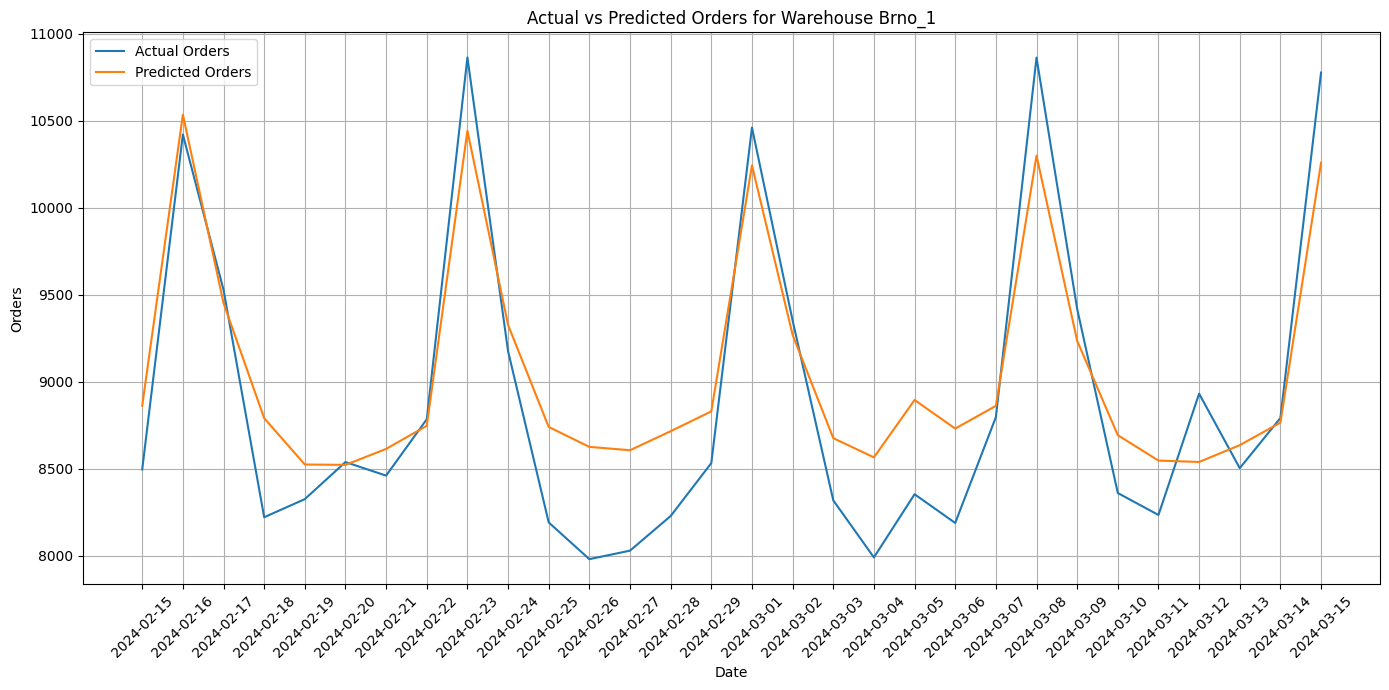

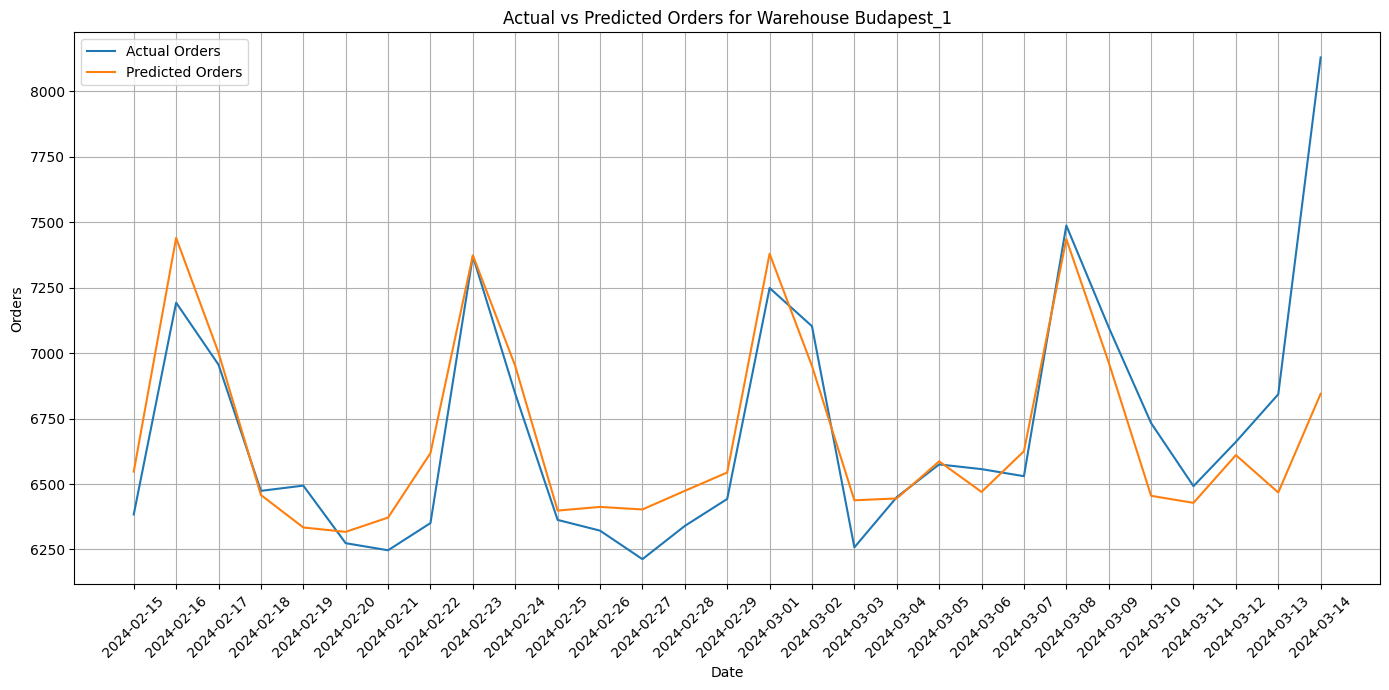

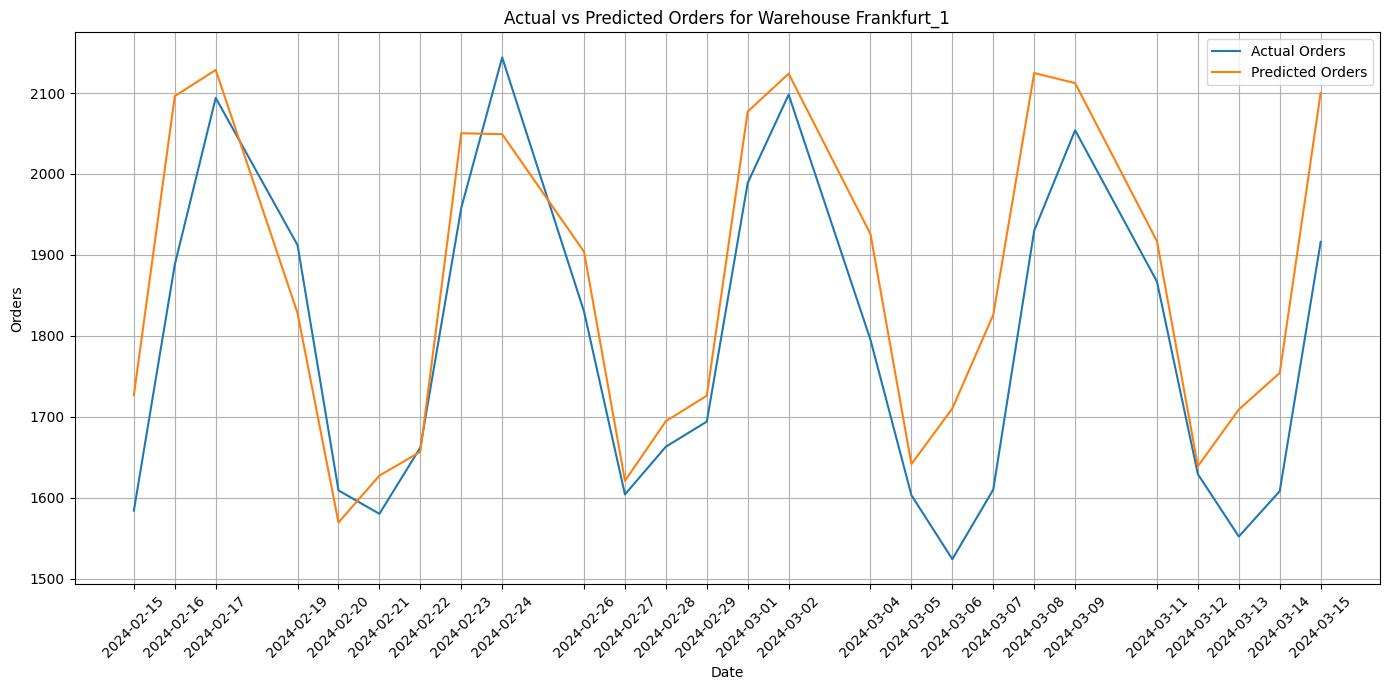

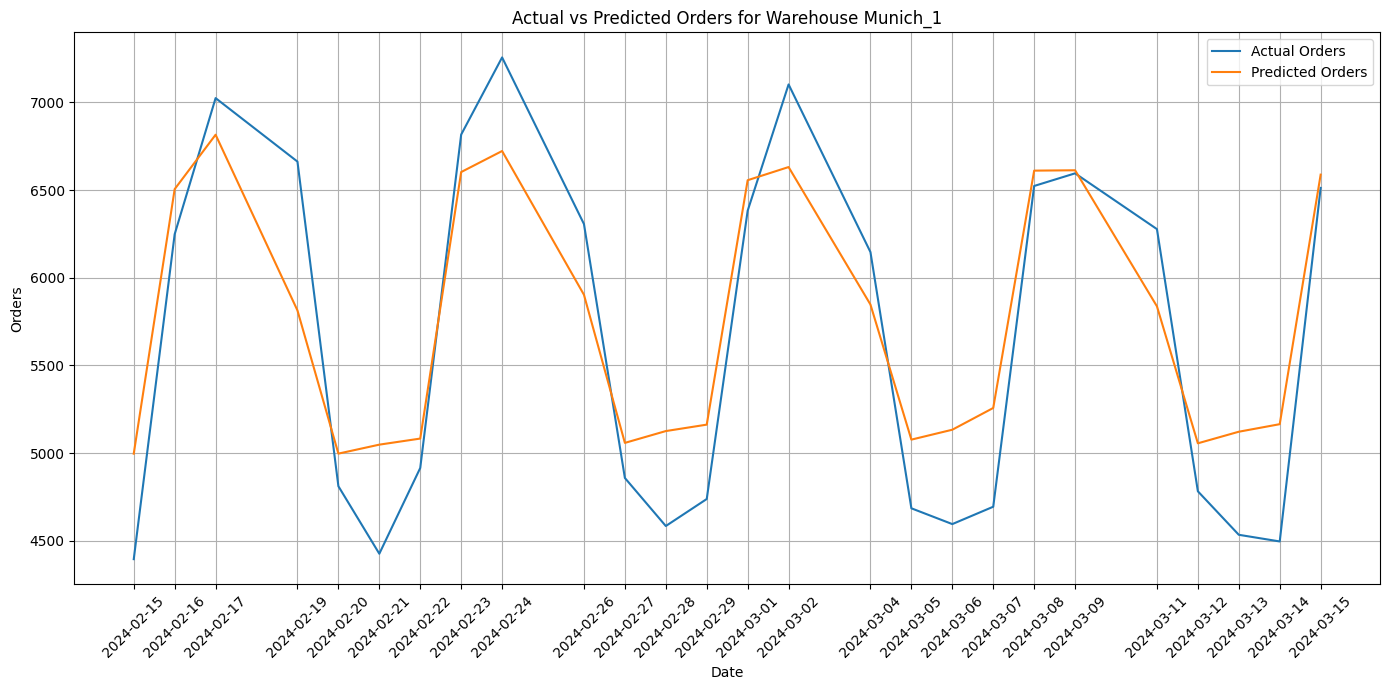

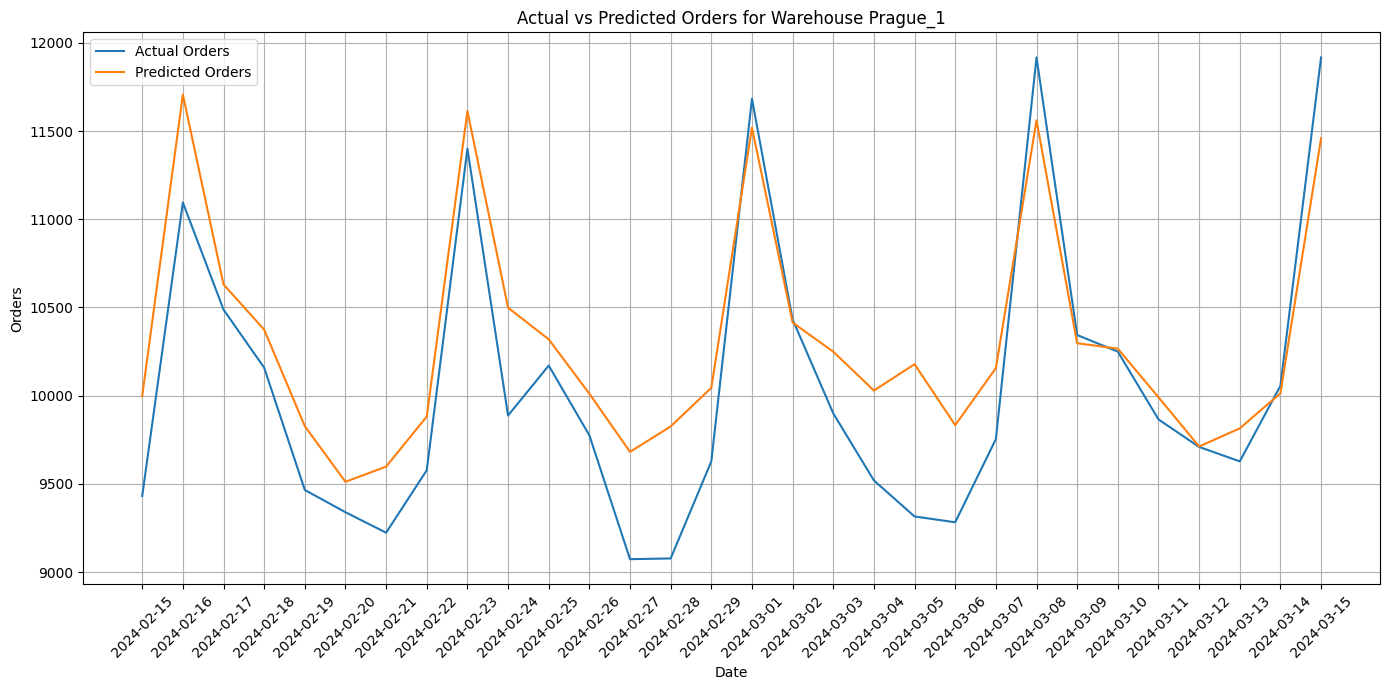

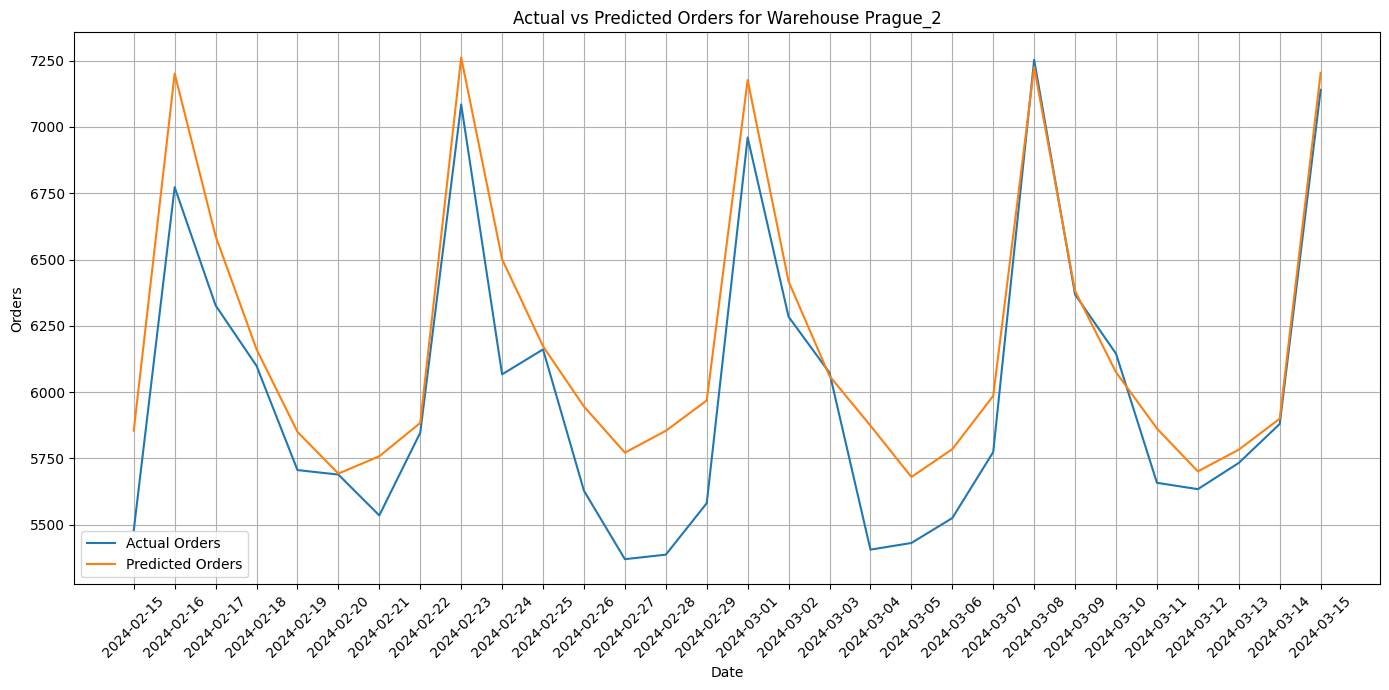

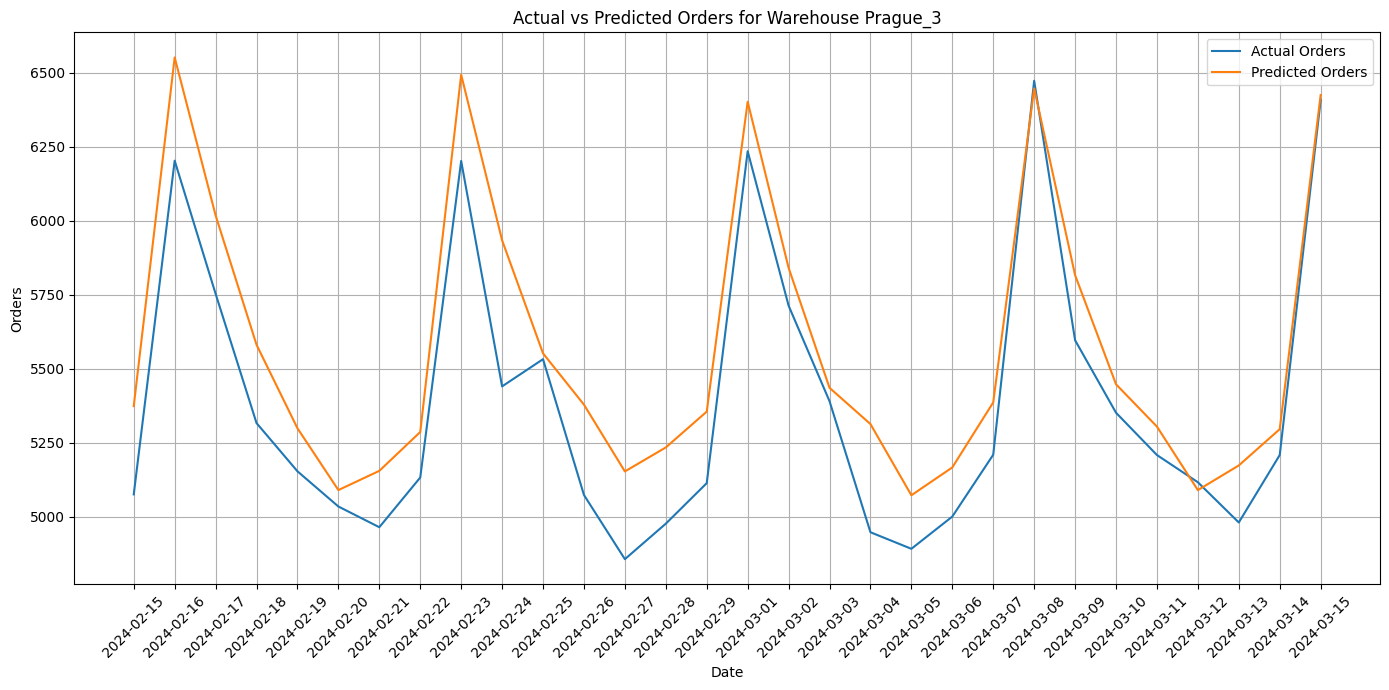

In [19]:
# Plotting the line chart per warehouse
warehouses = df_viz['warehouse'].unique()

for warehouse in warehouses:
    df_warehouse = df_viz[df_viz['warehouse'] == warehouse]
    plt.figure(figsize=(14, 7))
    plt.plot(df_warehouse['date'], df_warehouse['orders'], label='Actual Orders')
    plt.plot(df_warehouse['date'], df_warehouse['preds'], label='Predicted Orders')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.title(f'Actual vs Predicted Orders for Warehouse {warehouse}')
    plt.legend()
    plt.grid(True)
    plt.xticks(df_warehouse['date'], rotation=45)

    plt.tight_layout()
    plt.show()